# **Data Imputation <<< Starts from here >>>**

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# import fancyimpute

# os.chdir('C:/Users/mgow/Documents/UChicago/Courses/Data Mining/Group Project')
df = pd.read_csv('hospitalDataTarget.csv')

In [3]:
df.head()

,Unnamed: 0,Provider ID,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_10_POST_KIDNEY,...,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE,Hospital Name,Address,City,State,ZIP Code,Number of Completed Surveys,Survey Response Rate Percent
0,0,010001,3.0,14.5,4.5,8.9,12.5,16.2,13.7,0.65,...,83,86,84,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,506,21
1,1,010005,3.0,15.5,NaN,10.9,15.3,20.8,15.7,1.10,...,88,85,88,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957.0,1135,34
2,2,010006,3.6,14.9,3.2,8.8,13.2,17.2,17.2,1.28,...,84,82,84,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631.0,579,22
3,3,010007,2.8,NaN,NaN,8.3,13.3,21.6,15.9,1.30,...,85,86,85,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467.0,185,27
4,5,010011,2.6,14.1,3.7,8.9,13.1,16.1,12.4,1.74,...,87,81,86,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235.0,2193,33


In [4]:
# what is the pattern of the blank scores needing to be filled?

df.isnull().sum(axis=0)

Unnamed: 0                         0
Provider ID                        0
COMP_HIP_KNEE                    870
MORT_30_AMI                     1149
MORT_30_CABG                    2516
MORT_30_COPD                     438
MORT_30_HF                       291
MORT_30_PN                       196
MORT_30_STK                      991
PSI_10_POST_KIDNEY               828
PSI_11_POST_RESP                 848
PSI_12_POSTOP_PULMEMB_DVT        625
PSI_13_POST_SEPSIS               841
PSI_14_POSTOP_DEHIS              805
PSI_15_ACC_LAC                   655
PSI_3_ULCER                      573
PSI_4_SURG_COMP                 1823
PSI_6_IAT_PTX                    564
PSI_8_POST_HIP                   564
PSI_90_SAFETY                    562
PSI_9_POST_HEM                   628
H_CLEAN_LINEAR_SCORE               0
H_COMP_1_LINEAR_SCORE              0
H_COMP_2_LINEAR_SCORE              0
H_COMP_3_LINEAR_SCORE              0
H_COMP_5_LINEAR_SCORE              0
H_COMP_6_LINEAR_SCORE              0
H

Since they have less than half of the records populated, we will consider removing MORT_30_CABG and PSI_4_SURG_COMP when we run our models.

In [5]:
# set metadata - we will not impute values for these, but will add back later

df_metadata = df[['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code']]

In [6]:
df_survey_predictors = df[['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']]

df_survey_predictors.head()
df_survey_predictors.isnull().sum(axis=0)

COMP_HIP_KNEE                    870
MORT_30_AMI                     1149
MORT_30_CABG                    2516
MORT_30_COPD                     438
MORT_30_HF                       291
MORT_30_PN                       196
MORT_30_STK                      991
PSI_10_POST_KIDNEY               828
PSI_11_POST_RESP                 848
PSI_12_POSTOP_PULMEMB_DVT        625
PSI_13_POST_SEPSIS               841
PSI_14_POSTOP_DEHIS              805
PSI_15_ACC_LAC                   655
PSI_3_ULCER                      573
PSI_4_SURG_COMP                 1823
PSI_6_IAT_PTX                    564
PSI_8_POST_HIP                   564
PSI_90_SAFETY                    562
PSI_9_POST_HEM                   628
H_CLEAN_LINEAR_SCORE               0
H_COMP_1_LINEAR_SCORE              0
H_COMP_2_LINEAR_SCORE              0
H_COMP_3_LINEAR_SCORE              0
H_COMP_5_LINEAR_SCORE              0
H_COMP_6_LINEAR_SCORE              0
H_COMP_7_LINEAR_SCORE              0
H_HSP_RATING_LINEAR_SCORE          0
H

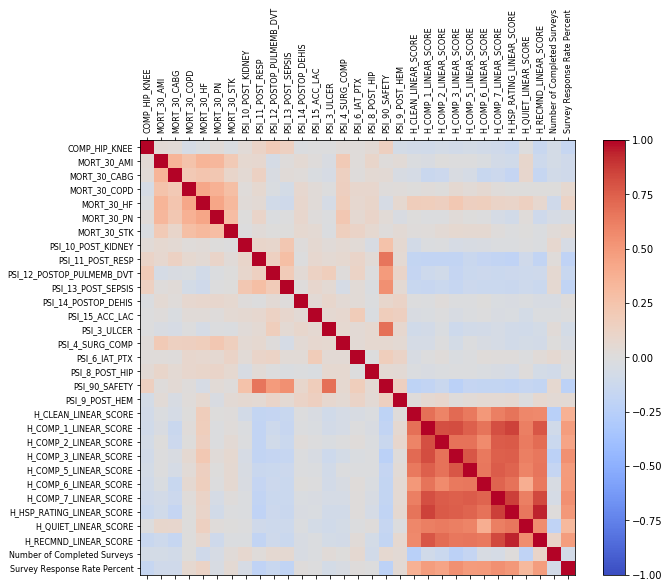

In [14]:

corr = df_survey_predictors.corr()
# fig = plt.figure()
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_survey_predictors.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_survey_predictors.columns, fontsize=8)
ax.set_yticklabels(df_survey_predictors.columns, fontsize=8)
plt.show()

Survey response rate % seems to be the most correlated with survey scores. However, there are 716 rows that don't have response rate provided, so we will have to work around that. Since the survey responses seem to be all or nothing (they are either all populated or all null), we can't use one survey response to predict another, despite the high correlation between them. In addition, all of the complication rates have missing values that will need to be examined separately and filled.

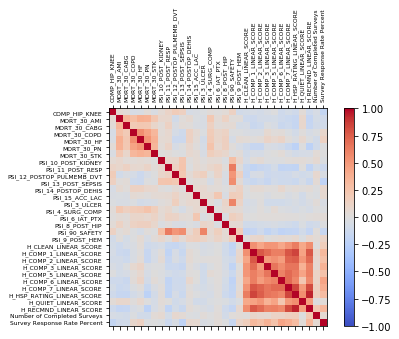

In [74]:
# out of curiosity - let's see how the correlation matrix is affected when you keep only 
# filled rows

df_predictors = df[['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']]
df_drop_na = df_predictors.dropna(how='any')
df_drop_na.count()

corr = df_drop_na.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_drop_na.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_drop_na.columns, fontsize=6)
ax.set_yticklabels(df_drop_na.columns, fontsize=6)
plt.show()

# doesn't particularly highlight other correlations, and actually removes the useful negative
# correlation between number of completed surveys and survey scores

We'll try two methods using fancyimpute. The first is IterativeImputer, which models each feature as a function of other features (mulitple regression). The second is KNN, which chooses the 3 nearest neighbors that have the feature filled and takes the average of those.

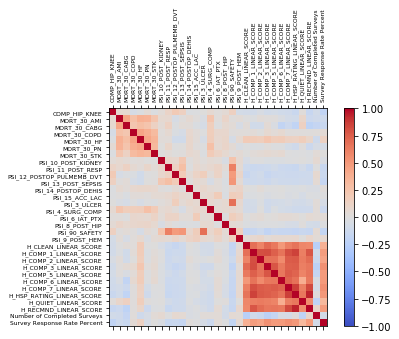

In [75]:
# Model each feature with missing values as a function of other features, and
# use that estimate for imputation.
#filled_iterative_np = fancyimpute.IterativeImputer().fit_transform(df_predictors)

df_filled_iterative = pd.DataFrame(filled_iterative_np)
df_filled_iterative.columns = ['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']
df_filled_iterative.head()

corr = df_filled_iterative.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_filled_iterative.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_filled_iterative.columns, fontsize=6)
ax.set_yticklabels(df_filled_iterative.columns, fontsize=6)
plt.show()

# looks like the correlations we saw before are generally retained

In [76]:
# look at means of each measure

df_filled_iterative.mean()

COMP_HIP_KNEE                     2.605102
MORT_30_AMI                      13.210216
MORT_30_CABG                      3.340519
MORT_30_COPD                      8.387088
MORT_30_HF                       11.750039
MORT_30_PN                       15.749078
MORT_30_STK                      14.243472
PSI_10_POST_KIDNEY                1.310920
PSI_11_POST_RESP                  8.110251
PSI_12_POSTOP_PULMEMB_DVT         3.802057
PSI_13_POST_SEPSIS                5.222166
PSI_14_POSTOP_DEHIS               0.857925
PSI_15_ACC_LAC                    1.290815
PSI_3_ULCER                       0.382598
PSI_4_SURG_COMP                 161.284288
PSI_6_IAT_PTX                     0.289004
PSI_8_POST_HIP                    0.110929
PSI_90_SAFETY                     0.996808
PSI_9_POST_HEM                    2.594627
H_CLEAN_LINEAR_SCORE             87.965146
H_COMP_1_LINEAR_SCORE            91.375177
H_COMP_2_LINEAR_SCORE            91.430434
H_COMP_3_LINEAR_SCORE            85.736753
H_COMP_5_LI

In [77]:
# Use 10 nearest rows which have a feature to fill in each row's missing features

filled_knn_np = fancyimpute.KNN(k=10).fit_transform(df_predictors)

Imputing row 1/3529 with 0 missing, elapsed time: 2.729
Imputing row 101/3529 with 1 missing, elapsed time: 2.739
Imputing row 201/3529 with 3 missing, elapsed time: 2.751
Imputing row 301/3529 with 0 missing, elapsed time: 2.756
Imputing row 401/3529 with 0 missing, elapsed time: 2.764
Imputing row 501/3529 with 2 missing, elapsed time: 2.779
Imputing row 601/3529 with 0 missing, elapsed time: 2.787
Imputing row 701/3529 with 0 missing, elapsed time: 2.791
Imputing row 801/3529 with 2 missing, elapsed time: 2.799
Imputing row 901/3529 with 2 missing, elapsed time: 2.813
Imputing row 1001/3529 with 1 missing, elapsed time: 2.819
Imputing row 1101/3529 with 2 missing, elapsed time: 2.830
Imputing row 1201/3529 with 13 missing, elapsed time: 2.846
Imputing row 1301/3529 with 8 missing, elapsed time: 2.860
Imputing row 1401/3529 with 10 missing, elapsed time: 2.874
Imputing row 1501/3529 with 2 missing, elapsed time: 2.885
Imputing row 1601/3529 with 16 missing, elapsed time: 2.890
Imputi

In [78]:
# convert knn np array back to dataframe and rename columns

df_filled_knn = pd.DataFrame(filled_knn_np)
df_filled_knn.columns = ['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']
df_filled_knn.head()
df_filled_knn.isnull().sum(axis=0)

COMP_HIP_KNEE                   0
MORT_30_AMI                     0
MORT_30_CABG                    0
MORT_30_COPD                    0
MORT_30_HF                      0
MORT_30_PN                      0
MORT_30_STK                     0
PSI_10_POST_KIDNEY              0
PSI_11_POST_RESP                0
PSI_12_POSTOP_PULMEMB_DVT       0
PSI_13_POST_SEPSIS              0
PSI_14_POSTOP_DEHIS             0
PSI_15_ACC_LAC                  0
PSI_3_ULCER                     0
PSI_4_SURG_COMP                 0
PSI_6_IAT_PTX                   0
PSI_8_POST_HIP                  0
PSI_90_SAFETY                   0
PSI_9_POST_HEM                  0
H_CLEAN_LINEAR_SCORE            0
H_COMP_1_LINEAR_SCORE           0
H_COMP_2_LINEAR_SCORE           0
H_COMP_3_LINEAR_SCORE           0
H_COMP_5_LINEAR_SCORE           0
H_COMP_6_LINEAR_SCORE           0
H_COMP_7_LINEAR_SCORE           0
H_HSP_RATING_LINEAR_SCORE       0
H_QUIET_LINEAR_SCORE            0
H_RECMND_LINEAR_SCORE           0
Number of Comp

In [79]:
# reattach provider IDs and location columns to datasets

final_filled_iterative = pd.concat([df_metadata, df_filled_iterative], axis=1)
final_filled_knn = pd.concat([df_metadata, df_filled_knn], axis=1)

In [80]:
# print iterativeImpute and knn filled datasets to csv

final_filled_iterative.to_csv('C:/Users/mgow/Documents/UChicago/Courses/Data Mining/Group Project/filled_iterative.csv')
final_filled_knn.to_csv('C:/Users/mgow/Documents/UChicago/Courses/Data Mining/Group Project/filled_knn.csv')

In [145]:
#import the required packages
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

In [146]:
## Upload CSV File
Hospital_data = pd.read_csv('/Users/michaeldiarra/OneDrive/Samsung Ultra/U Chicago Ms Analytics/Program/Spring 2019/MSCA 31008 01 - Data Mining Principles/Graded Assignments/Group Project/hospitalDataTarget.csv')
Hospital_data.head(2)

,Unnamed: 0,Provider ID,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_10_POST_KIDNEY,...,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE,Hospital Name,Address,City,State,ZIP Code,Number of Completed Surveys,Survey Response Rate Percent
0,0,010001,3.0,14.5,4.5,8.9,12.5,16.2,13.7,0.65,...,83,86,84,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,506,21
1,1,010005,3.0,15.5,NaN,10.9,15.3,20.8,15.7,1.10,...,88,85,88,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957.0,1135,34


In [148]:
# Explore dataset
Hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3529 entries, 0 to 3528
Data columns (total 38 columns):
Unnamed: 0                      3529 non-null int64
Provider ID                     3529 non-null object
COMP_HIP_KNEE                   2659 non-null float64
MORT_30_AMI                     2380 non-null float64
MORT_30_CABG                    1013 non-null float64
MORT_30_COPD                    3091 non-null float64
MORT_30_HF                      3238 non-null float64
MORT_30_PN                      3333 non-null float64
MORT_30_STK                     2538 non-null float64
PSI_10_POST_KIDNEY              2701 non-null float64
PSI_11_POST_RESP                2681 non-null float64
PSI_12_POSTOP_PULMEMB_DVT       2904 non-null float64
PSI_13_POST_SEPSIS              2688 non-null float64
PSI_14_POSTOP_DEHIS             2724 non-null float64
PSI_15_ACC_LAC                  2874 non-null float64
PSI_3_ULCER                     2956 non-null float64
PSI_4_SURG_COMP                 

In [149]:
# Explore missing values
import warnings
warnings.filterwarnings('ignore')
total = Hospital_data.isnull().sum().sort_values(ascending=False)
percent = Hospital_data.isnull().sum()/Hospital_data.isnull().count()*100
percent_2H = (round(percent, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Number of missing Values','Percentage of missing values'])
missing_data

,Number of missing Values,Percentage of missing values
Address,0,0.000000
COMP_HIP_KNEE,870,24.652876
City,0,0.000000
H_CLEAN_LINEAR_SCORE,0,0.000000
H_COMP_1_LINEAR_SCORE,0,0.000000
H_COMP_2_LINEAR_SCORE,0,0.000000
H_COMP_3_LINEAR_SCORE,0,0.000000
H_COMP_5_LINEAR_SCORE,0,0.000000
H_COMP_6_LINEAR_SCORE,0,0.000000
H_COMP_7_LINEAR_SCORE,0,0.000000


In [150]:
# Compute Column non-missing values mean
Hospital_data['COMP_HIP_KNEE'].describe()

count    2659.000000
mean        2.598270
std         0.520227
min         1.200000
25%         2.200000
50%         2.500000
75%         2.900000
max         5.400000
Name: COMP_HIP_KNEE, dtype: float64

In [151]:
# Use the computed mean to impute missing values
mean_value = 2.598270
data = [Hospital_data]

for dataset in data:
    dataset['COMP_HIP_KNEE'] = dataset['COMP_HIP_KNEE'].fillna(mean_value)

In [152]:
# Compute Column non-missing values mean
Hospital_data['MORT_30_AMI'].describe()

count    2380.000000
mean       13.172227
std         1.220191
min         8.900000
25%        12.400000
50%        13.100000
75%        13.900000
max        18.700000
Name: MORT_30_AMI, dtype: float64

In [153]:
# Use the computed mean to impute missing values
mean_value = 13.172227
data = [Hospital_data]

for dataset in data:
    dataset['MORT_30_AMI'] = dataset['MORT_30_AMI'].fillna(mean_value)

In [154]:
# Compute Column non-missing values mean
Hospital_data['MORT_30_CABG'].describe()

count    1013.000000
mean        3.230405
std         0.951815
min         1.300000
25%         2.600000
50%         3.000000
75%         3.700000
max         8.500000
Name: MORT_30_CABG, dtype: float64

In [155]:
# Use the computed mean to impute missing values
mean_value = 3.230405
data = [Hospital_data]

for dataset in data:
    dataset['MORT_30_CABG'] = dataset['MORT_30_CABG'].fillna(mean_value)

In [156]:
# Compute Column non-missing values mean
Hospital_data['MORT_30_COPD'].describe()

count    3091.000000
mean        8.409609
std         1.153897
min         4.900000
25%         7.600000
50%         8.300000
75%         9.100000
max        14.400000
Name: MORT_30_COPD, dtype: float64

In [157]:
# Use the computed mean to impute missing values
mean_value = 8.409609
data = [Hospital_data]

for dataset in data:
    dataset['MORT_30_COPD'] = dataset['MORT_30_COPD'].fillna(mean_value)

In [158]:
# Compute Column non-missing values mean
Hospital_data['MORT_30_HF'].describe()

count    3238.000000
mean       11.720568
std         1.757129
min         5.000000
25%        10.500000
50%        11.600000
75%        12.900000
max        18.500000
Name: MORT_30_HF, dtype: float64

In [159]:
# Use the computed mean to impute missing values
mean_value = 11.720568
data = [Hospital_data]

for dataset in data:
    dataset['MORT_30_HF'] = dataset['MORT_30_HF'].fillna(mean_value)

In [160]:
# Compute Column non-missing values mean
Hospital_data['MORT_30_PN'].describe()

count    3333.000000
mean       15.772187
std         2.051998
min         9.000000
25%        14.400000
50%        15.700000
75%        17.000000
max        24.800000
Name: MORT_30_PN, dtype: float64

In [161]:
# Use the computed mean to impute missing values
mean_value = 15.772187
data = [Hospital_data]

for dataset in data:
    dataset['MORT_30_PN'] = dataset['MORT_30_PN'].fillna(mean_value)

In [162]:
# Compute Column non-missing values mean
Hospital_data['MORT_30_STK'].describe()

count    2538.000000
mean       14.284555
std         1.526956
min         8.900000
25%        13.300000
50%        14.200000
75%        15.200000
max        21.400000
Name: MORT_30_STK, dtype: float64

In [163]:
# Use the computed mean to impute missing values
mean_value = 14.284555
data = [Hospital_data]

for dataset in data:
    dataset['MORT_30_STK'] = dataset['MORT_30_STK'].fillna(mean_value)

In [164]:
# Compute Column non-missing values mean
Hospital_data['PSI_10_POST_KIDNEY'].describe()

count    2701.000000
mean        1.307827
std         0.313357
min         0.330000
25%         1.180000
50%         1.270000
75%         1.310000
max         4.310000
Name: PSI_10_POST_KIDNEY, dtype: float64

In [165]:
# Use the computed mean to impute missing values
mean_value = 1.307827
data = [Hospital_data]

for dataset in data:
    dataset['PSI_10_POST_KIDNEY'] = dataset['PSI_10_POST_KIDNEY'].fillna(mean_value)

In [166]:
# Compute Column non-missing values mean
Hospital_data['PSI_11_POST_RESP'].describe()

count    2681.000000
mean        8.047139
std         2.950221
min         1.550000
25%         6.160000
50%         7.370000
75%         9.440000
max        34.750000
Name: PSI_11_POST_RESP, dtype: float64

In [167]:
# Use the computed mean to impute missing values
mean_value = 8.047139
data = [Hospital_data]

for dataset in data:
    dataset['PSI_11_POST_RESP'] = dataset['PSI_11_POST_RESP'].fillna(mean_value)

In [168]:
# Compute Column non-missing values mean
Hospital_data['PSI_12_POSTOP_PULMEMB_DVT'].describe()

count    2904.000000
mean        3.812930
std         0.924873
min         1.210000
25%         3.250000
50%         3.680000
75%         4.240000
max         9.820000
Name: PSI_12_POSTOP_PULMEMB_DVT, dtype: float64

In [169]:
# Use the computed mean to impute missing values
mean_value = 3.812930
data = [Hospital_data]

for dataset in data:
    dataset['PSI_12_POSTOP_PULMEMB_DVT'] = dataset['PSI_12_POSTOP_PULMEMB_DVT'].fillna(mean_value)

In [170]:
# Compute Column non-missing values mean
Hospital_data['PSI_13_POST_SEPSIS'].describe()

count    2688.000000
mean        5.214059
std         1.081294
min         2.090000
25%         4.610000
50%         5.050000
75%         5.660000
max        14.450000
Name: PSI_13_POST_SEPSIS, dtype: float64

In [171]:
# Use the computed mean to impute missing values
mean_value = 5.214059
data = [Hospital_data]

for dataset in data:
    dataset['PSI_13_POST_SEPSIS'] = dataset['PSI_13_POST_SEPSIS'].fillna(mean_value)

In [172]:
# Compute Column non-missing values mean
Hospital_data['PSI_14_POSTOP_DEHIS'].describe()

count    2724.000000
mean        0.857948
std         0.251599
min         0.270000
25%         0.730000
50%         0.800000
75%         0.840000
max         2.700000
Name: PSI_14_POSTOP_DEHIS, dtype: float64

In [173]:
# Use the computed mean to impute missing values
mean_value = 0.857948
data = [Hospital_data]

for dataset in data:
    dataset['PSI_14_POSTOP_DEHIS'] = dataset['PSI_14_POSTOP_DEHIS'].fillna(mean_value)

In [174]:
# Compute Column non-missing values mean
Hospital_data['PSI_15_ACC_LAC'].describe()

count    2874.000000
mean        1.290052
std         0.238634
min         0.570000
25%         1.160000
50%         1.250000
75%         1.380000
max         2.980000
Name: PSI_15_ACC_LAC, dtype: float64

In [175]:
# Use the computed mean to impute missing values
mean_value = 1.290052
data = [Hospital_data]

for dataset in data:
    dataset['PSI_15_ACC_LAC'] = dataset['PSI_15_ACC_LAC'].fillna(mean_value)

In [176]:
# Compute Column non-missing values mean
Hospital_data['PSI_3_ULCER'].describe()

count    2956.000000
mean        0.383332
std         0.429161
min         0.020000
25%         0.170000
50%         0.280000
75%         0.440000
max        12.600000
Name: PSI_3_ULCER, dtype: float64

In [177]:
# Use the computed mean to impute missing values
mean_value = 0.383332
data = [Hospital_data]

for dataset in data:
    dataset['PSI_3_ULCER'] = dataset['PSI_3_ULCER'].fillna(mean_value)

In [178]:
# Compute Column non-missing values mean
Hospital_data['PSI_4_SURG_COMP'].describe()

count    1706.000000
mean      161.794959
std        17.033773
min        96.820000
25%       150.687500
50%       160.900000
75%       172.277500
max       225.890000
Name: PSI_4_SURG_COMP, dtype: float64

In [179]:
# Use the computed mean to impute missing values
mean_value = 161.794959
data = [Hospital_data]

for dataset in data:
    dataset['PSI_4_SURG_COMP'] = dataset['PSI_4_SURG_COMP'].fillna(mean_value)

In [180]:
# Compute Column non-missing values mean
Hospital_data['PSI_6_IAT_PTX'].describe()

count    2965.000000
mean        0.287423
std         0.048992
min         0.110000
25%         0.260000
50%         0.280000
75%         0.310000
max         0.680000
Name: PSI_6_IAT_PTX, dtype: float64

In [181]:
# Use the computed mean to impute missing values
mean_value = 0.287423
data = [Hospital_data]

for dataset in data:
    dataset['PSI_6_IAT_PTX'] = dataset['PSI_6_IAT_PTX'].fillna(mean_value)

In [182]:
# Compute Column non-missing values mean
Hospital_data['PSI_8_POST_HIP'].describe()

count    2965.000000
mean        0.110958
std         0.009690
min         0.080000
25%         0.110000
50%         0.110000
75%         0.110000
max         0.170000
Name: PSI_8_POST_HIP, dtype: float64

In [183]:
# Use the computed mean to impute missing values
mean_value = 0.110958
data = [Hospital_data]

for dataset in data:
    dataset['PSI_8_POST_HIP'] = dataset['PSI_8_POST_HIP'].fillna(mean_value)

In [184]:
# Compute Column non-missing values mean
Hospital_data['PSI_90_SAFETY'].describe()

count    2967.000000
mean        0.994392
std         0.180281
min         0.520000
25%         0.890000
50%         0.970000
75%         1.070000
max         4.210000
Name: PSI_90_SAFETY, dtype: float64

In [185]:
# Use the computed mean to impute missing values
mean_value = 0.994392
data = [Hospital_data]

for dataset in data:
    dataset['PSI_90_SAFETY'] = dataset['PSI_90_SAFETY'].fillna(mean_value)

In [186]:
# Compute Column non-missing values mean
Hospital_data['PSI_9_POST_HEM'].describe()

count    2901.000000
mean        2.589211
std         0.362182
min         1.290000
25%         2.410000
50%         2.540000
75%         2.730000
max         4.690000
Name: PSI_9_POST_HEM, dtype: float64

In [187]:
# Use the computed mean to impute missing values
mean_value = 2.589211
data = [Hospital_data]

for dataset in data:
    dataset['PSI_9_POST_HEM'] = dataset['PSI_9_POST_HEM'].fillna(mean_value)

In [188]:
# Explore missing values
import warnings
warnings.filterwarnings('ignore')
total = Hospital_data.isnull().sum().sort_values(ascending=False)
percent = Hospital_data.isnull().sum()/Hospital_data.isnull().count()*100
percent_2H = (round(percent, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Number of missing Values','Percentage of missing values'])
missing_data

,Number of missing Values,Percentage of missing values
Address,0,0.0
COMP_HIP_KNEE,0,0.0
City,0,0.0
H_CLEAN_LINEAR_SCORE,0,0.0
H_COMP_1_LINEAR_SCORE,0,0.0
H_COMP_2_LINEAR_SCORE,0,0.0
H_COMP_3_LINEAR_SCORE,0,0.0
H_COMP_5_LINEAR_SCORE,0,0.0
H_COMP_6_LINEAR_SCORE,0,0.0
H_COMP_7_LINEAR_SCORE,0,0.0


In [189]:
# Explore dataset
Hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3529 entries, 0 to 3528
Data columns (total 38 columns):
Unnamed: 0                      3529 non-null int64
Provider ID                     3529 non-null object
COMP_HIP_KNEE                   3529 non-null float64
MORT_30_AMI                     3529 non-null float64
MORT_30_CABG                    3529 non-null float64
MORT_30_COPD                    3529 non-null float64
MORT_30_HF                      3529 non-null float64
MORT_30_PN                      3529 non-null float64
MORT_30_STK                     3529 non-null float64
PSI_10_POST_KIDNEY              3529 non-null float64
PSI_11_POST_RESP                3529 non-null float64
PSI_12_POSTOP_PULMEMB_DVT       3529 non-null float64
PSI_13_POST_SEPSIS              3529 non-null float64
PSI_14_POSTOP_DEHIS             3529 non-null float64
PSI_15_ACC_LAC                  3529 non-null float64
PSI_3_ULCER                     3529 non-null float64
PSI_4_SURG_COMP                 

In [190]:
Hospital_data.head(2)

,Unnamed: 0,Provider ID,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_10_POST_KIDNEY,...,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE,Hospital Name,Address,City,State,ZIP Code,Number of Completed Surveys,Survey Response Rate Percent
0,0,010001,3.0,14.5,4.500000,8.9,12.5,16.2,13.7,0.65,...,83,86,84,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,506,21
1,1,010005,3.0,15.5,3.230405,10.9,15.3,20.8,15.7,1.10,...,88,85,88,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957.0,1135,34


In [191]:
# Export Data to a CSV File
Hospital_data.to_csv(r'/Users/michaeldiarra/OneDrive/Samsung Ultra/U Chicago Ms Analytics/Program/Spring 2019/MSCA 31008 01 - Data Mining Principles/Graded Assignments/Group Project/hospitalDataTarget_MeanImpute.csv')